In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from dlc_practical_prologue import generate_pair_sets

In [152]:
torch.manual_seed(1)

In [157]:
train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(1000)
train_input, train_target, train_classes, test_input, test_target, test_classes = \
train_input.cuda(), train_target.cuda(), train_classes.cuda(), test_input.cuda(), test_target.cuda(), test_classes.cuda()
train_input.size()    

torch.Size([1000, 2, 14, 14])

In [159]:
def stardarize_data(train_data, test_data):
    mean, std = train_data.mean(), train_data.std()
    
    return (train_data - mean) / std, (test_data - mean) / std

train_input, test_input = stardarize_data(train_input, test_input)

In [96]:
class PairModel(nn.Module):
    def __init__(self, nbch1=32, nbch2=64, nbfch=256, batch_norm=True, skip_connections=True):
        super(PairModel, self).__init__()
        self.nbch1 = nbch1
        self.nbch2 = nbch2
        self.nbfch = nbfch
        self.batch_norm = batch_norm
        self.skip_connections = skip_connections
        self.conv1 = nn.Conv2d(2, nbch1, 3)
        if batch_norm:
            self.bn1 = nn.BatchNorm2d(nbch1)
        if skip_connections:
            self.skip1 = nn.Linear(2*14*14, nbch1*6*6)
        self.conv2 = nn.Conv2d(nbch1, nbch2, 6)
        if batch_norm:
            self.bn2 = nn.BatchNorm2d(nbch2)
        if skip_connections:
            self.skip2 = nn.Linear(2*14*14, nbch2*1*1)
        self.fc1 = nn.Linear(nbch2, nbfch)
        self.fc2 = nn.Linear(nbfch, 2)
    def forward(self, x):
        if self.batch_norm:
            y = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), 2))
            if self.skip_connections:
                y += F.relu(self.skip1(x.view(x.size(0), 2*14*14)).view(y.size()))
            y = F.relu(self.bn2(self.conv2(y)))
            if self.skip_connections:
                y += F.relu(self.skip2(x.view(x.size(0), 2*14*14)).view(y.size()))
        else:
            y = F.relu(F.max_pool2d(self.conv1(x), 2))
            if self.skip_connections:
                y += F.relu(self.skip1(x.view(x.size(0), 2*14*14)).view(y.size()))
            y = F.relu(self.conv2(y))
            if self.skip_connections:
                y += F.relu(self.skip2(x.view(x.size(0), 2*14*14)).view(y.size()))
        y = F.relu(self.fc1(y.view(-1, self.nbch2)))
        return F.relu(self.fc2(y))

In [148]:
def train_pair_model(nbch1=32, nbch2=64, nbfch=256, batch_norm=True, skip_connections=True,
                     num_epochs=25, lr=0.1, mini_batch_size=100, verbose=False):
    model = PairModel(nbch1, nbch2, nbfch, batch_norm, skip_connections).cuda()
    num_samples = train_input.size(0)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss().cuda()
    pair_model_grad_norms = []
    for e in range(num_epochs):
        sum_loss = 0
        for b in range(0, num_samples, mini_batch_size):
            input_mini_batch = train_input[b:b + mini_batch_size]
            target_mini_batch = train_target[b:b + mini_batch_size]
            model.zero_grad()
            prediction = model(input_mini_batch)
            loss = criterion(prediction, target_mini_batch)
            sum_loss += loss.item()
            loss.backward()
            optimizer.step()
        if verbose:
            print(e, sum_loss)
        pair_model_grad_norms.append([param.grad.norm().item() for name, param in model.named_parameters() if "bias" not in name])
    return model, pair_model_grad_norms

In [95]:
class SiameseModel(nn.Module):
    def __init__(self, nbch1=32, nbch2=64, nbfch=256, batch_norm=True, skip_connections=True):
        super(SiameseModel, self).__init__()
        self.nbch1 = nbch1
        self.nbch2 = nbch2
        self.nbfch = nbfch
        self.batch_norm = batch_norm
        self.skip_connections = skip_connections
        self.conv1 = nn.Conv2d(1, nbch1, 3)
        if batch_norm:
            self.bn1 = nn.BatchNorm2d(nbch1)
        if skip_connections:
            self.skip1 = nn.Linear(1*14*14, nbch1*6*6)
        self.conv2 = nn.Conv2d(nbch1, nbch2, 6)
        if batch_norm:
            self.bn2 = nn.BatchNorm2d(nbch2)
        if skip_connections:
            self.skip2 = nn.Linear(1*14*14, nbch2*1*1)
        self.fc1 = nn.Linear(nbch2, nbfch)
        self.fc2 = nn.Linear(nbfch, 10)
        self.fc3 = nn.Linear(20, 2)
    def forward(self, x):
        x1, x2 = x[:, 0], x[:, 1]
        x1 = x1.reshape(-1, 1, 14, 14)
        x2 = x2.reshape(-1, 1, 14, 14)
        if self.batch_norm:
            y1 = F.relu(F.max_pool2d(self.bn1(self.conv1(x1)), 2))
            y2 = F.relu(F.max_pool2d(self.bn1(self.conv1(x2)), 2))
            if self.skip_connections:
                y1 += F.relu(self.skip1(x1.view(x1.size(0), 1*14*14)).view(y1.size()))
                y2 += F.relu(self.skip1(x2.view(x1.size(0), 1*14*14)).view(y2.size()))
            y1 = F.relu(self.bn2(self.conv2(y1)))
            y2 = F.relu(self.bn2(self.conv2(y2)))
            if self.skip_connections:
                y1 += F.relu(self.skip2(x1.view(x1.size(0), 1*14*14)).view(y1.size()))
                y2 += F.relu(self.skip2(x2.view(x2.size(0), 1*14*14)).view(y2.size()))
        else:
            y1 = F.relu(F.max_pool2d(self.conv1(x1), 2))
            y2 = F.relu(F.max_pool2d(self.conv1(x2), 2))
            if self.skip_connections:
                y1 += F.relu(self.skip1(x1.view(x1.size(0), 1*14*14)).view(y1.size()))
                y2 += F.relu(self.skip1(x2.view(x1.size(0), 1*14*14)).view(y2.size()))
            y1 = F.relu(self.conv2(y1))
            y2 = F.relu(self.conv2(y2))
            if self.skip_connections:
                y1 += F.relu(self.skip2(x1.view(x1.size(0), 1*14*14)).view(y1.size()))
                y2 += F.relu(self.skip2(x2.view(x2.size(0), 1*14*14)).view(y2.size()))
        y1 = F.relu(self.fc1(y1.view(-1, self.nbch2)))
        y1 = F.relu(self.fc2(y1))
        y2 = F.relu(self.fc1(y2.view(-1, self.nbch2)))
        y2 = F.relu(self.fc2(y2))
        y = torch.cat((y1, y2), axis=1)
        return F.relu(self.fc3(y)), (y1, y2)

In [149]:
def train_siamese_model(nbch1=32, nbch2=64, nbfch=256, batch_norm=True, skip_connections=True,
                        num_epochs=25, lr=0.1, mini_batch_size=100, loss_weights=(1, 1), verbose=False):
    model = SiameseModel(nbch1, nbch2, nbfch, batch_norm, skip_connections).cuda()
    num_samples = train_input.size(0)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss().cuda()
    siamese_model_grad_norms = []
    for e in range(num_epochs):
        sum_loss = 0
        for b in range(0, num_samples, mini_batch_size):
            input_mini_batch = train_input[b:b + mini_batch_size]
            target_mini_batch = train_target[b:b + mini_batch_size]
            classes_mini_batch = train_classes[b:b + mini_batch_size]
            model.zero_grad()
            prediction_2, (prediction_10_1, prediction_10_2) = model(input_mini_batch)
            loss_2 = criterion(prediction_2, target_mini_batch)
            loss_10_1 = criterion(prediction_10_1, classes_mini_batch[:, 0])
            loss_10_2 = criterion(prediction_10_2, classes_mini_batch[:, 1])
            loss_10 = loss_10_1 + loss_10_2
            total_loss = loss_weights[0] * loss_2 + loss_weights[1] * loss_10
            total_loss.backward()
            sum_loss += total_loss.item()
            optimizer.step()
        if verbose:
            print(e, sum_loss)
        siamese_model_grad_norms.append([param.grad.norm().item() for name, param in model.named_parameters() if "bias" not in name])
    return model, siamese_model_grad_norms

In [142]:
def test_pair_model(model):
    num_samples = test_input.size(0)
    prediction = model(test_input)
    predicted_class = torch.argmax(prediction, axis=1)
    accuracy = torch.sum(predicted_class == test_target).float() / num_samples
    return accuracy

In [69]:
trained_pair_model = train_pair_model(lr=1e-1)

0 6.887147903442383
1 6.4775550365448
2 5.173625081777573
3 3.8548147678375244
4 2.9081957042217255
5 2.0111269801855087
6 1.4107759594917297
7 0.9711647890508175
8 0.5560696385800838
9 0.28876807540655136
10 0.16739739757031202
11 0.1142818396911025
12 0.08582414966076612
13 0.0682602059096098
14 0.05623815627768636
15 0.04763617552816868
16 0.04121305141597986
17 0.0361858659889549
18 0.03221911867149174
19 0.028954045614227653
20 0.026248782640323043
21 0.02398349903523922
22 0.02206000778824091
23 0.020373227423988283
24 0.018916542641818523


In [70]:
test_pair_model(trained_pair_model)

tensor(0.8190)

In [81]:
trained_siamese_model = train_siamese_model(lr=0.25, loss_weights=(1.5, 0.25))

0 19.749149203300476
1 15.131879210472107
2 11.78531539440155
3 8.651716530323029
4 7.372188925743103
5 5.835291713476181
6 5.320942312479019
7 4.2074973583221436
8 5.134718835353851
9 2.1422751992940903
10 1.0305017456412315
11 0.6569100171327591
12 0.48365792632102966
13 0.37246683053672314
14 0.3002510517835617
15 0.2481361236423254
16 0.207585615105927
17 0.17532976251095533
18 0.14919528272002935
19 0.12857546377927065
20 0.11149497795850039
21 0.09739922964945436
22 0.08561994647607207
23 0.07584058260545135
24 0.06806869152933359


In [143]:
def test_siamese_model(model):
    num_samples = test_input.size(0)
    prediction_2, (prediction_10_1, prediction_10_2) = model(test_input)
    predicted_class_2 = torch.argmax(prediction_2, axis=1)
    predicted_class_10_1 = torch.argmax(prediction_10_1, axis=1)
    predicted_class_10_2 = torch.argmax(prediction_10_2, axis=1)
    predicted_class_10 = predicted_class_10_1 <= predicted_class_10_2
    accuracy_2 = torch.sum(predicted_class_2 == test_target).float() / num_samples
    accuracy_10 = torch.sum(predicted_class_10 == test_target).float() / num_samples
    return accuracy_2, accuracy_10

In [83]:
test_siamese_model(trained_siamese_model)

(tensor(0.8640), tensor(0.9620))

 ### ToDo
 - gradient norm over depth vs usage of batch_norm
 - cross-val of learn_rate, siamese_loss_weights, num_channels, num_linear_hidden
 - one loss test accuracy vs two losses(augmented) test accuracy
 - possibly, 20->2 probs with linear vs non-linear transform
 - impact of initializations, normalizing input, adding skip connections, dropout...?

In [89]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

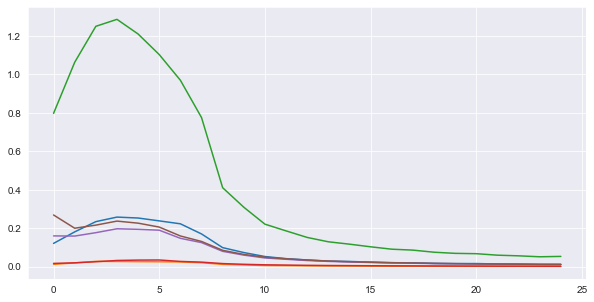

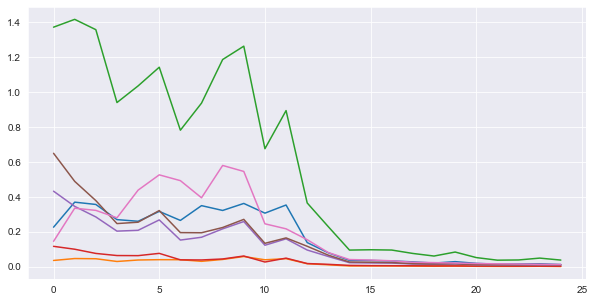

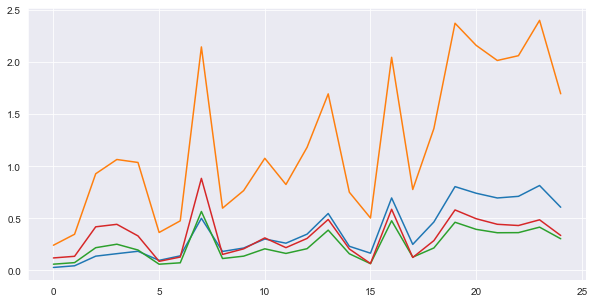

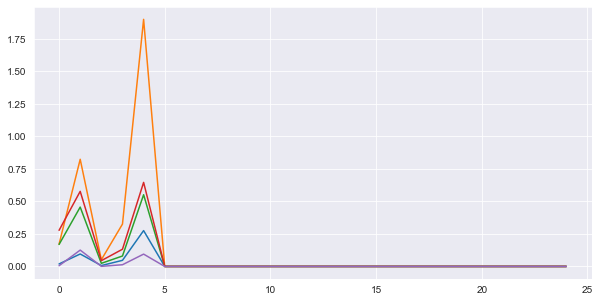

In [160]:
import numpy as np
for use_batch_norm in (True, False):
    trained_pair_model, pair_model_grad_norms = train_pair_model(lr=1e-1, batch_norm=use_batch_norm, skip_connections=False)
    trained_siamese_model, siamese_model_grad_norms = train_siamese_model(lr=0.25, batch_norm=use_batch_norm, skip_connections=False)
    
    pair_model_grad_norms = np.array(pair_model_grad_norms)
    siamese_model_grad_norms = np.array(siamese_model_grad_norms)
    plt.figure(figsize=(10, 5))
    for i in range(pair_model_grad_norms.shape[1]):
        sns.lineplot(x=range(pair_model_grad_norms.shape[0]), y=pair_model_grad_norms[:, i])
    plt.show()
    plt.figure(figsize=(10, 5))
    for i in range(siamese_model_grad_norms.shape[1]):
        sns.lineplot(x=range(siamese_model_grad_norms.shape[0]), y=siamese_model_grad_norms[:, i])
    plt.show()

In [145]:
from random import sample
param_grid = [(int(nbch1), int(nbch2), int(nbfch), batch_norm, skip_connections, lr)
    for nbch1 in np.logspace(3, 7, 5, base=2)
    for nbch2 in np.logspace(3, 7, 5, base=2)
    for nbfch in np.logspace(6, 10, 5, base=2)
    for batch_norm in (True, False)
    for skip_connections in (True, False)
    for lr in (0.001, 0.1, 0.25, 1)]

pair_model_scores={}
pair_model_stds={}
siamese_model_scores_2={}
siamese_model_scores_10={}
siamese_model_stds_2={}
siamese_model_stds_10={}
for param_combo in param_grid:
    pair_model_scores[param_combo] = []
    siamese_model_scores_2[param_combo] = []
    siamese_model_scores_10[param_combo] = []
    nbch1, nbch2, nbfch, batch_norm, skip_connections, lr = param_combo
    for i in range(10):
        train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(1000)
        train_input, test_input = stardarize_data(train_input, test_input)
        train_input, test_input, train_target, test_target = train_input.cuda(), test_input.cuda(), train_target.cuda(), test_target.cuda()
        trained_pair_model, _ = train_pair_model(nbch1, nbch2, nbfch, batch_norm, skip_connections, lr=lr)
        train_classes, test_classes = train_classes.cuda(), test_classes.cuda()
        trained_siamese_model, _ = train_siamese_model(nbch1, nbch2, nbfch, batch_norm, skip_connections, lr=lr)
        pair_model_scores[param_combo].append(test_pair_model(trained_pair_model))
        score_2, score_10 = test_siamese_model(trained_siamese_model)
        siamese_model_scores_2[param_combo].append(score_2)
        siamese_model_scores_10[param_combo].append(score_10)
    scores = pair_model_scores[param_combo]
    pair_model_scores[param_combo] = sum(scores) / 10
    pair_model_stds[param_combo] = torch.FloatTensor(scores).std()
    scores = siamese_model_scores_2[param_combo]
    siamese_model_scores_2[param_combo] = sum(scores) / 10
    siamese_model_stds_2[param_combo] = torch.FloatTensor(scores).std()
    scores = siamese_model_scores_10[param_combo]
    siamese_model_scores_10[param_combo] = sum(scores) / 10
    siamese_model_stds_10[param_combo] = torch.FloatTensor(scores).std()
    print(param_combo, pair_model_scores[param_combo], pair_model_stds[param_combo])
    print(param_combo, siamese_model_scores_2[param_combo], siamese_model_stds_2[param_combo], siamese_model_scores_10[param_combo], siamese_model_stds_10[param_combo])

(8, 8, 64, True, True, 0.001) tensor(0.5411, device='cuda:0') tensor(0.0282)
(8, 8, 64, True, True, 0.001) tensor(0.5016, device='cuda:0') tensor(0.0366) tensor(0.5972, device='cuda:0') tensor(0.0353)
(8, 8, 64, True, True, 0.1) tensor(0.7292, device='cuda:0') tensor(0.1217)
(8, 8, 64, True, True, 0.1) tensor(0.8176, device='cuda:0') tensor(0.0642) tensor(0.8368, device='cuda:0') tensor(0.1066)


KeyboardInterrupt: 